In [27]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics.pairwise import rbf_kernel

In [28]:
# =============================================================================
# 0. Configuration: folders and image size
# =============================================================================
CLEAN_FOLDER = 'data\\anatomicalSegmentations'
DIST_FOLDER  = 'data\\anatomicalSegmentationsDistorted'
IMG_SIZE     = (64, 64)    # resize to 64×64

In [29]:
# =============================================================================
# 1. Utility: load all .png images from a folder, resize, and stack
# =============================================================================
def load_images_from_folder(folder, size=IMG_SIZE):
    """
    Loads all .png images (grayscale) from `folder`, resizes them to `size`,
    and returns a numpy array of shape (N, size[0], size[1]).
    """
    filepaths = sorted(glob(os.path.join(folder, '*.png')))
    imgs = []
    for fp in filepaths:
        img = imread(fp, as_gray=True)
        img = resize(img, size, anti_aliasing=True)  # ensures values in [0,1]
        imgs.append(img)
    return np.stack(imgs, axis=0)

In [30]:
# Load clean and distorted datasets
clean_imgs = load_images_from_folder(CLEAN_FOLDER)    # shape: (M, 64,64)
dist_imgs  = load_images_from_folder(DIST_FOLDER)     # shape: (K, 64,64)
M, H, W    = clean_imgs.shape
K          = dist_imgs.shape[0]

# Vectorize images to shape (N, 4096)
X_clean = clean_imgs.reshape(M, -1)
X_dist  = dist_imgs.reshape(K, -1)


In [31]:
# =============================================================================
# 2. Part 4(a): PCA on the clean segmentation images
# =============================================================================

# (a.i) Compute PCA, extract eigen‑spectrum
pca = PCA()
pca.fit(X_clean)
eigvals = pca.explained_variance_        # λ₁ ≥ λ₂ ≥ ...
pcs     = pca.components_               # each row is a principal component (4096‑dim)
mean_vec = pca.mean_                    # mean image vector

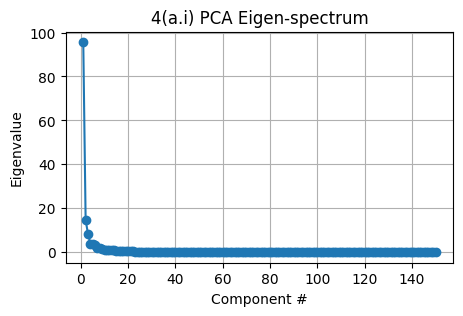

In [32]:
# Plot eigen‑spectrum
plt.figure(figsize=(5,3))
plt.plot(np.arange(1, len(eigvals)+1), eigvals, 'o-')
plt.title("4(a.i) PCA Eigen‑spectrum")
plt.xlabel("Component #")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

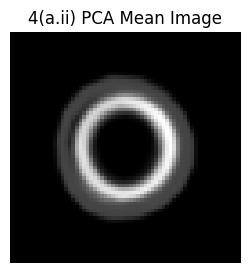

In [33]:
# (a.ii) Show the mean image
mean_img = mean_vec.reshape(H, W)
plt.figure(figsize=(3,3))
plt.imshow(mean_img, cmap='gray')
plt.title("4(a.ii) PCA Mean Image")
plt.axis('off')
plt.show()

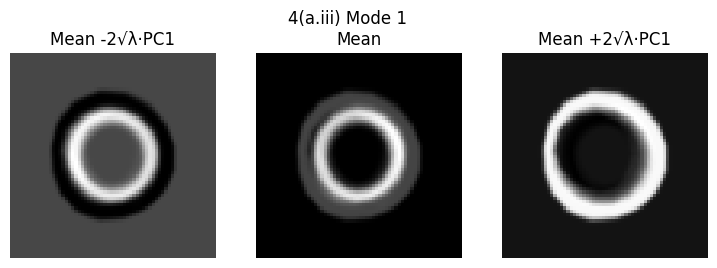

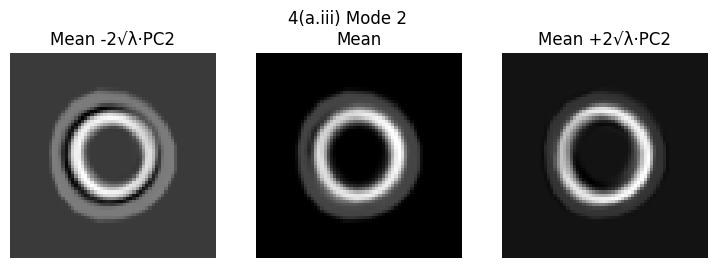

In [34]:
# (a.iii) Show first two modes of variation ±2√λ along PC1 and PC2
def plot_pca_mode(pc_vec, eigval, idx):
    mode_img = pc_vec.reshape(H, W)
    std = np.sqrt(eigval)
    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    axs[0].imshow(mean_img - 2*std*mode_img, cmap='gray')
    axs[0].set_title(f"Mean -2√λ·PC{idx}")
    axs[1].imshow(mean_img, cmap='gray')
    axs[1].set_title("Mean")
    axs[2].imshow(mean_img + 2*std*mode_img, cmap='gray')
    axs[2].set_title(f"Mean +2√λ·PC{idx}")
    for ax in axs: ax.axis('off')
    plt.suptitle(f"4(a.iii) Mode {idx}")
    plt.show()

plot_pca_mode(pcs[0], eigvals[0], idx=1)
plot_pca_mode(pcs[1], eigvals[1], idx=2)

In [35]:
# =============================================================================
# 3. Part 4(b): Kernel PCA (RBF)
# =============================================================================
gamma = 1e-3
kpca = KernelPCA(kernel='rbf',
                 gamma=gamma,
                 fit_inverse_transform=True,
                 n_components=50)
kpca.fit(X_clean)

# 4(b.i) Compute the RKHS kernel matrix and its centered eigenvalues
Kmat = rbf_kernel(X_clean, gamma=gamma)  # (M,M)
one_n = np.ones((M, M)) / M
Kc = Kmat - one_n @ Kmat - Kmat @ one_n + one_n @ Kmat @ one_n
# eigen‑decompose
eigvals_kpca, _ = np.linalg.eigh(Kc)
# sort descending
eigvals_kpca = np.sort(eigvals_kpca)[::-1]

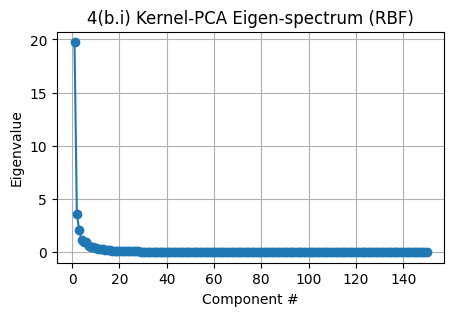

In [36]:

plt.figure(figsize=(5,3))
plt.plot(np.arange(1, len(eigvals_kpca)+1), eigvals_kpca, 'o-')
plt.title("4(b.i) Kernel‑PCA Eigen‑spectrum (RBF)")
plt.xlabel("Component #")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.show()

In [37]:
# (b.ii) Pre‑image of the RKHS mean (which is at the origin in feature space)
zero_feat = np.zeros(kpca.n_components)
preimage = kpca.inverse_transform(zero_feat).reshape(H, W)

plt.figure(figsize=(3,3))
plt.imshow(preimage, cmap='gray')
plt.title("4(b.ii) KPCA Pre‑image of RKHS Mean")
plt.axis('off')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# =============================================================================
# 4. Part 4(c): Denoising distorted images via PCA and Kernel PCA
# =============================================================================

# (c.i) PCA projection onto first 3 PCs and reconstruction
pcs3 = pcs[:3]          # first 3 principal components
eig3 = eigvals[:3]

recon_pca = []
for x in X_dist:
    coeffs = (x - mean_vec) @ pcs3.T     # project to 3D
    x_rec  = mean_vec + coeffs @ pcs3    # reconstruct 4096‑dim
    recon_pca.append(x_rec.reshape(H, W))
recon_pca = np.stack(recon_pca, axis=0)

# (c.ii) Kernel‑PCA projection onto first 3 dims and pre‑image reconstruction
recon_kpca = []
for x in X_dist:
    z_full = kpca.transform(x.reshape(1, -1))[0]  # full 50‑dim embedding
    z3 = np.zeros_like(z_full)
    z3[:3] = z_full[:3]                           # keep only first 3 dims
    xk_rec = kpca.inverse_transform(z3).reshape(H, W)
    recon_kpca.append(xk_rec)
recon_kpca = np.stack(recon_kpca, axis=0)

# Display a few examples side‑by‑side
n_show = min(5, K)
fig, axs = plt.subplots(n_show, 4, figsize=(12, 3*n_show))
for i in range(n_show):
    axs[i,0].imshow(dist_imgs[i], cmap='gray')
    axs[i,0].set_title("Distorted")
    axs[i,1].imshow(recon_pca[i], cmap='gray')
    axs[i,1].set_title("4(c.i) PCA Recon")
    axs[i,2].imshow(recon_kpca[i], cmap='gray')
    axs[i,2].set_title("4(c.ii) KPCA Recon")
    axs[i,3].imshow(clean_imgs[i], cmap='gray')
    axs[i,3].set_title("Clean Ref")
    for j in range(4):
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()
